In [1]:
# %%
import os 

import numpy as np
from numpy.core.records import record
from numpy.lib.function_base import disp
import pandas as pd
from numba import jit

from IPython.display import display

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.cm as cm 
# %%
def readRecord(path, id):
    # recordFileName = f'records/record-{id}.csv'
    recordFileName = os.path.join(path, 'records', f'record-{id}.csv')

    # return pd.read_table(recordFileName, sep = ',', keep_default_na=False, na_values='')
    return pd.read_csv(recordFileName, sep = ',', keep_default_na=False, na_values=[], na_filter=False)

def readDependency(path, maxDependentTxns=10):
    dependencyFileName = os.path.join(path, "dependency.csv")
    deps = pd.read_csv(dependencyFileName, error_bad_lines=False, header=None, names=range(maxDependentTxns))
    deps = deps.rename(columns={0: 'Transaction ID'}).iloc[1:, :]
    isAscending = deps['Transaction ID'].is_monotonic_increasing
    if isAscending:
        boolStr = "True"
    else:
        boolStr = "False"
    print("Is the dependency file Monotonic Increasing: ", boolStr)
    # deps = deps[1:]
    return deps

def readRecords(path, serverNum):
    recordList = [readRecord(path, serverId) for serverId in range(serverNum)]
    return pd.concat(recordList).sort_values(by='Transaction ID', ascending=True).replace(0, np.NaN)

def avgRecords(records, path, isOutputFile=False):
    avg = np.mean(records)
    avgFilePath = os.path.join(path, 'avg.csv')
    if isOutputFile:
        avg.to_csv(avgFilePath)
    return avg
# %%
def convertDatatype(deps, records, isSubtractCacheTime=False, isSubtractLockTime=False):
    depsNp = deps.to_numpy()

    executionTimes = records[['Transaction ID', 'Execution Time']]
    if isSubtractCacheTime:
        executionTimes['Execution Time'] = executionTimes['Execution Time'] - (records['Read from cache'].fillna(0))

    if isSubtractLockTime:
        executionTimes['Execution Time'] = executionTimes['Execution Time'] - (records['Get locks'].fillna(0))
    
    executionTimes['Execution Time'] = executionTimes['Execution Time']
    print("Execution Time with shape: ", executionTimes.shape)
    display(executionTimes)

    startTimestamps = records[['Transaction ID', 'Txn Start TimeStamp']]
    print("Start Timestamps with shape: ", startTimestamps.shape)
    display(startTimestamps)

    endTimestamps = records[['Transaction ID', 'Txn End TimeStamp']]
    print("End Timestamps with shape: ", endTimestamps.shape)
    display(endTimestamps)

    executionTimesDict = executionTimes.set_index('Transaction ID')['Execution Time'].to_dict()
    startTimestampDict = startTimestamps.set_index('Transaction ID')['Txn Start TimeStamp'].to_dict()
    endTimestampDict = endTimestamps.set_index('Transaction ID')['Txn End TimeStamp'].to_dict()

    return depsNp, executionTimesDict, startTimestampDict, endTimestampDict

# @jit(forceobj=True)
def computePredPro(deps, executionTimes, startTimestamp, endTimestamp, isRecursive=True):
    txnPredEndingTime = []
    txnPredEndingTimeDic = {}
    txnNum = deps.shape[0]
    dependingTxnNum = 0
    nonBlockDependingTxnNum = 0

    for idx in range(txnNum):
        row = deps[idx]
        # print("Row: ", row)

        txn = row[0]
        # print(txn)
        txnStartTime = startTimestamp[txn]

        depTxns = row[1:]
        depTxns = depTxns[~np.isnan(depTxns)].tolist()
        # print(depTxns)

        depTimes = []
        for depTxn in depTxns:
            # depTimes.append(endTimestamp[depTxn])
            if isRecursive:
                # The prediction is based on the predicted values before
                endTime = txnPredEndingTimeDic.get(depTxn, None)
                if endTime != None:
                    depTimes.append(endTime)
                else:
                    depTimes.append(0)
            else:
                # The prediction is based on the exact txn ending timestamp
                depTimes.append(endTimestamp[depTxn])
        # print("Dep Times: ", depTimes)

        if len(depTimes) == 0:
            maxDepTime = txnStartTime
        else:    
            maxDepTime = np.max(depTimes)
            dependingTxnNum = dependingTxnNum + 1
            # If the dependent Txns finished before Txn starts, then take "maxDepTime" as the start time of Txn.
            if maxDepTime < txnStartTime:
                nonBlockDependingTxnNum = nonBlockDependingTxnNum + 1
                maxDepTime = txnStartTime
        # print("Max Dep Time: ", maxDepTime)

        txnExeTime = executionTimes[txn]
        # print(txnExeTime)

        # Actual Ending/Starting Time
        actualTxnEndTime = endTimestamp[txn]
        actualTxnStartTime = startTimestamp[txn]

        # Convert to long integer
        newTxnLong = np.int64(txn)
        newEndTimeLong = np.int64(maxDepTime) + np.int64(txnExeTime)
        newActualEndTimeLong = np.int64(actualTxnEndTime)
        newActualStartTimeLong = np.int64(actualTxnStartTime)
        new_row = [newTxnLong, newEndTimeLong, newActualEndTimeLong, newActualStartTimeLong]
        
        # Update list and dict of predicted ending timestamp
        txnPredEndingTime.append(new_row)
        txnPredEndingTimeDic[newEndTimeLong] = newEndTimeLong

    print(f'Txns classes: {nonBlockDependingTxnNum}/{dependingTxnNum}/{deps.shape[0]}')

    return np.array(txnPredEndingTime), nonBlockDependingTxnNum, dependingTxnNum, deps.shape[0]

def plotTransTime(path, records, predEndTimes, warmupDrop=90000000, groupNum=300, isSaveFig=True):
    # Drop warm up rows
    beforeDropSahpe = predEndTimes.shape
    afterWarmUpTxns = dropWarmUpRows(predEndTimes=predEndTimes, warmupDrop=warmupDrop)
    trim = records[records['Transaction ID'].isin(afterWarmUpTxns)]
    trim = trim.sort_values(by='Transaction ID', ascending=True)
    trim = trim.reset_index()
    afterDropSahpe = trim.shape
    print(f'Dropped warm up Txns, shape: {beforeDropSahpe} -> {afterDropSahpe}')
    display(trim)

    # Group Mean
    num, div = getGroupDiv(dfRowNum=trim.shape[0], groupNum=groupNum)
    transChoosen = trim.loc[0:num, ["Trans Time Of Remote Read"]].to_numpy()
    print(f'groupNum: {groupNum}, div: {div}, transChoosen: {transChoosen.shape}')
    transChoosenMean = np.squeeze(np.nanmean(np.reshape(transChoosen, (-1, div)), axis=1))
    print(f'Trans Group Mean: {transChoosenMean.shape}')

    # Data points on X-axis
    xdots = np.linspace(0, groupNum - 1, groupNum)

    fig = figure(figsize=(16, 9), dpi=120)
    plt.plot(xdots, transChoosenMean, label="Transmission Time")
    # plt.yscale("log")
    plt.xlabel("TxNum")
    plt.ylabel("Transmission Time (in microsec)")
    # plt.suptitle(f'The residual between Predicted Ending Time and Actual Ending Time(RMSD: {rmsd}, {infos})', y=1.01)
    plt.title(f'The transmission time during benchmark')

    plt.legend()
    plt.tight_layout()
    plt.grid()

    figFileName = os.path.join(path, f'trans.png')
    if isSaveFig:
        fig.savefig(figFileName, facecolor='white', edgecolor='white', bbox_inches='tight')
    plt.show()

def dropWarmUpRows(predEndTimes, warmupDrop=90000000):
    # Drop warm up rows
    beforeDropSahpe = predEndTimes.shape
    warmupDropTimestamp = predEndTimes.loc[1, 'Actual Starting Time'] + warmupDrop
    print(f'Warm Up Drop Timestamp: {warmupDropTimestamp}')
    trim = predEndTimes.loc[predEndTimes['Actual Starting Time'] > warmupDropTimestamp, :]
    return trim['Transaction ID'].to_numpy()

def getGroupDiv(dfRowNum, groupNum=300):
    # groupNum = 300
    div = (dfRowNum // groupNum)
    num = dfRowNum
    if div < 1:
        print(f'Total size of residual < {groupNum}, no aggregation')
    else:
        num = groupNum * div - 1
        print(f'groupNum * div - 1: {num}')
    return num, div

def plot(path, predEndTimes, nonBlockDependingTxnNum, dependingTxnNum, TxnNum, isRecursive, isSubtractCacheTime, isSubtractLockTime, warmupDrop=90000000, groupNum=300, isSaveFig=True):
    # Add a serial number for each Txn
    seqs = np.linspace(0, predEndTimes.shape[0] - 1, predEndTimes.shape[0])
    predEndTimes['TxNum'] = seqs

    # trim = predEndTimes
    # trim = predEndTimes.loc[predEndTimes['Predicted Ending Time'] > 10000000, :]

    # Append residual column
    predEndTimes['residual'] = predEndTimes['Actual Ending Time'] - predEndTimes['Predicted Ending Time']
    predEndTimes['absolute value of residual'] = np.absolute((predEndTimes['Actual Ending Time'] - predEndTimes['Predicted Ending Time']).to_numpy())

    # Drop warm up rows
    beforeDropSahpe = predEndTimes.shape
    # warmupDropTimestamp = predEndTimes.loc[1, 'Actual Starting Time'] + warmupDrop
    # print(f'Warm Up Drop Timestamp: {warmupDropTimestamp}')
    # trim = predEndTimes.loc[predEndTimes['Actual Starting Time'] > warmupDropTimestamp, :]
    afterWarmUpTxns = dropWarmUpRows(predEndTimes=predEndTimes, warmupDrop=warmupDrop)
    trim = predEndTimes[predEndTimes['Transaction ID'].isin(afterWarmUpTxns)]
    trim = trim.sort_values(by='Transaction ID', ascending=True)
    trim = trim.reset_index()
    afterDropSahpe = trim.shape
    print(f'Dropped warm up Txns, shape: {beforeDropSahpe} -> {afterDropSahpe}')

    # Set up infos
    correlation = np.corrcoef(trim['Predicted Ending Time'], trim['Actual Ending Time'])[0, 1]
    # predVar = np.var(trim['Predicted Ending Time'])
    # actVar = np.var(trim['Actual Ending Time'])
    txnClass = f'Non Blocking Txns: {nonBlockDependingTxnNum} | Depending Txns: {dependingTxnNum} |  Txn Num: {TxnNum} | corr: {correlation}'
    infos = f'Rec: {isRecursive}, ' + f'SubCache: {isSubtractCacheTime}, ' + f'SubLock: {isSubtractLockTime}'
    fileNameInfos = ''
    if isRecursive:
        fileNameInfos = fileNameInfos + '-R'
    if isSubtractCacheTime:
        fileNameInfos = fileNameInfos + '-NC'
    if isSubtractLockTime:
        fileNameInfos = fileNameInfos + '-NL'

    # RMSD
    rmsd = np.sqrt(np.mean(trim['residual'] * trim['residual'], axis=None))
    print("RMSD: ", rmsd)
    print("Table for plotting regression with shape: ", trim.shape)
    display(trim)

    # Scatter
    fig = figure(figsize=(16, 9), dpi=120)
    sc = plt.scatter(trim['Predicted Ending Time'], trim['Actual Ending Time'], c=trim['TxNum'])
    colorBar = plt.colorbar(sc)
    # plt.scatter(trim['Predicted Ending Time'], trim['Actual Ending Time'])
    
    plt.xlabel("Predicted Ending Time in micro-sec")
    plt.ylabel("Actual Ending Time in micro-sec")
    plt.suptitle(f'The scatter plot of Predicted Ending Time and Actual Ending Time(RMSD: {rmsd}, {infos})', y=1.01)
    plt.title(f'{txnClass}')

    plt.legend()
    plt.tight_layout()
    plt.grid()

    figFileName = os.path.join(path, f'regression{fileNameInfos}.png')
    if isSaveFig:
        fig.savefig(figFileName, facecolor='white', edgecolor='white', bbox_inches='tight')
    plt.show()

    # The residual plot
    fig = figure(figsize=(16, 9), dpi=120)

    num, div = getGroupDiv(dfRowNum=trim.shape[0], groupNum=groupNum)
    residualChoosen = trim.loc[0:num, ["residual"]].to_numpy()
    absResidualChoosen = trim.loc[0:num, ["absolute value of residual"]].to_numpy()
    print(f'groupNum: {groupNum}, div: {div}, residualChoosen: {residualChoosen.shape}')
    residualGroupMean = np.squeeze(np.mean(np.reshape(residualChoosen, (-1, div)), axis=1))
    absResidualGroupMean = np.squeeze(np.mean(np.reshape(absResidualChoosen, (-1, div)), axis=1))
    print(f'Residual Group Mean: {residualGroupMean.shape}')

    # Data points on X-axis
    xdots = np.linspace(0, groupNum - 1, groupNum)

    plt.plot(xdots, residualGroupMean, label="Residual")
    plt.plot(xdots, absResidualGroupMean, label="Absolute value")
    # plt.yscale("log")
    plt.xlabel("TxNum")
    plt.ylabel("Residual = real - prediction(in microsec)")
    plt.suptitle(f'The residual between Predicted Ending Time and Actual Ending Time(RMSD: {rmsd}, {infos})', y=1.01)
    plt.title(f'{txnClass}')

    plt.legend()
    plt.tight_layout()
    plt.grid()

    figFileName = os.path.join(path, f'residual{fileNameInfos}.png')
    if isSaveFig:
        fig.savefig(figFileName, facecolor='white', edgecolor='white', bbox_inches='tight')
    plt.show()

def readDatasets(path, recNum, isOutputAvgFile=True):
    # Read records
    records = readRecords(path, recNum)
    print(f'Records with shape: {records.shape}')
    display(records)

    avgRecs = avgRecords(records, path, isOutputFile=isOutputAvgFile)
    print(f'Avg of Records with shape: {avgRecs.shape}')
    display(avgRecs)

    # Read Dependency
    depsFull = readDependency(path, maxDependentTxns=10)

    return records, avgRecs, depsFull

def regressPlot(path, records, depsFull, analyzeTxnNum=None, isRecursive=True, isSubtractCacheTime=False, isSubtractLockTime=False, warmupDrop=90000000, groupNum=300, isPlotTransTime=False, isSaveFig=True):
    # Truncate dependency length
    if analyzeTxnNum != None:
        deps = depsFull[:analyzeTxnNum]
    else:
        deps = depsFull
    print(f'Dependency with shape: {deps.shape}')
    display(deps)

    depsNp, executionTimesDict, startTimestampDict, endTimestampDict = convertDatatype(deps, records, isSubtractCacheTime=isSubtractCacheTime, isSubtractLockTime=isSubtractLockTime)

    # Compute dependency
    predEndTimesNp, nonBlockDependingTxnNum, dependingTxnNum, TxnNum = computePredPro(depsNp, executionTimesDict, startTimestampDict, endTimestampDict, isRecursive=isRecursive)
    predEndTimes = pd.DataFrame(predEndTimesNp, columns=['Transaction ID', 'Predicted Ending Time', 'Actual Ending Time', 'Actual Starting Time'])

    # Plot
    plot(path, predEndTimes, 
         nonBlockDependingTxnNum, dependingTxnNum, TxnNum, 
         isRecursive=isRecursive, isSubtractCacheTime=isSubtractCacheTime, isSubtractLockTime=isSubtractLockTime, warmupDrop=warmupDrop, groupNum=groupNum, isSaveFig=isSaveFig)
    if isPlotTransTime:
        plotTransTime(path, records, predEndTimes, warmupDrop=warmupDrop, groupNum=groupNum, isSaveFig=isSaveFig)

def regression(path, recNum, nonBlockDependingTxnNum, dependingTxnNum, TxnNum, isOutputAvgFile, analyzeTxnNum=None, isRecursive=True, isSubtractCacheTime=False, isSubtractLockTime=False):
    records = readRecords(path, recNum)
    print(f'Records with shape: {records.shape}')
    display(records)

    avgRecs = avgRecords(records, path, isOutputFile=isOutputAvgFile)
    print(f'Avg of Records with shape: {avgRecs.shape}')
    display(avgRecs)

    depsFull = readDependency(path, maxDependentTxns=10)
    if analyzeTxnNum != None:
        deps = depsFull[:analyzeTxnNum]
    else:
        deps = depsFull
    print(f'Dependency with shape: {deps.shape}')
    display(deps)

    depsNp, executionTimesDict, startTimestampDict, endTimestampDict = convertDatatype(deps, records, 
                                                                                       isSubtractCacheTime=isSubtractCacheTime, 
                                                                                       isSubtractLockTime=isSubtractLockTime)

    predEndTimesNp = computePredPro(depsNp, executionTimesDict, startTimestampDict, endTimestampDict, isRecursive=isRecursive)
    predEndTimes = pd.DataFrame(predEndTimesNp, columns=['Transaction ID', 'Predicted Ending Time', 'Actual Ending Time', 'Actual Starting Time'])

    plot(path, predEndTimes, isRecursive=isRecursive, 
         isSubtractCacheTime=isSubtractCacheTime, isSubtractLockTime=isSubtractLockTime)

In [2]:
path = f'reports/Google-RTE_50-BS_1'
recNum = 4
isOutputAvgFile = True
analyzeTxnNum = None
isRecursive=True
isSubtractCacheTime=True
isSubtractLockTime=False
warmupDrop=90000000
groupNum=300
isSaveFig=False

In [3]:
records = readRecords(path, recNum)
print(f'Records with shape: {records.shape}')
display(records)

avgRecs = avgRecords(records, path, isOutputFile=isOutputAvgFile)
print(f'Avg of Records with shape: {avgRecs.shape}')
display(avgRecs)

In [ ]:
depsFull = readDependency(path, maxDependentTxns=10)
if analyzeTxnNum != None:
    deps = depsFull[:analyzeTxnNum]
else:
    deps = depsFull
print(f'Dependency with shape: {deps.shape}')
display(deps)

depsNp, executionTimesDict, startTimestampDict, endTimestampDict = convertDatatype(deps, records, 
                                                                                   isSubtractCacheTime=isSubtractCacheTime,
                                                                                   isSubtractLockTime=isSubtractLockTime)

Is the dependency file Monotonic Increasing:  True
Dependency with shape: (849718, 10)


Transaction ID          1          2          3   4   5   6   7   8  \
1                    3        2.0        NaN        NaN NaN NaN NaN NaN NaN   
2                    7        NaN        NaN        NaN NaN NaN NaN NaN NaN   
3                   11        NaN        NaN        NaN NaN NaN NaN NaN NaN   
4                   16        NaN        NaN        NaN NaN NaN NaN NaN NaN   
5                   20        NaN        NaN        NaN NaN NaN NaN NaN NaN   
...                ...        ...        ...        ...  ..  ..  ..  ..  ..   
849714         5395822  5129033.0  5390414.0  5089232.0 NaN NaN NaN NaN NaN   
849715         5395833  2852657.0        NaN        NaN NaN NaN NaN NaN NaN   
849716         5395834  4248754.0        NaN        NaN NaN NaN NaN NaN NaN   
849717         5395861  2967280.0        NaN        NaN NaN NaN NaN NaN NaN   
849718         5395863  4833730.0        NaN        NaN NaN NaN NaN NaN NaN   

         9  
1      NaN  
2      NaN  
3      NaN  
4      NaN  
5      NaN  
...     ..  
849714 NaN  
849715 NaN  
849716 NaN  
849717 NaN  
849718 NaN  

[849718 rows x 10 columns]

Execution Time with shape:  (5829030, 2)


/home/weidagogo/anaconda3/envs/tempenv/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/weidagogo/anaconda3/envs/tempenv/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Transaction ID  Execution Time
0                     1        740458.0
0                     2        768120.0
1                     3        772633.0
0                     4        870438.0
0                     5        767736.0
...                 ...             ...
3365751         5395900           226.0
3365752         5395901            26.0
3365753         5395902           224.0
3365754         5395903           547.0
3365755         5395904           485.0

[5829030 rows x 2 columns]

Start Timestamps with shape:  (5829030, 2)


Transaction ID  Txn Start TimeStamp
0                     1         422053834436
0                     2         422053806966
1                     3         422053806966
0                     4         422054635584
0                     5         422054264403
...                 ...                  ...
3365751         5395900         422359523048
3365752         5395901         422359523053
3365753         5395902         422359523367
3365754         5395903         422359523556
3365755         5395904         422359523626

[5829030 rows x 2 columns]

End Timestamps with shape:  (5829030, 2)


Transaction ID  Txn End TimeStamp
0                     1       422054574893
0                     2       422054575083
1                     3       422054579596
0                     4       422055506021
0                     5       422055032137
...                 ...                ...
3365751         5395900       422359523274
3365752         5395901       422359523080
3365753         5395902       422359523591
3365754         5395903       422359524103
3365755         5395904       422359524112

[5829030 rows x 2 columns]

In [ ]:
def getTxlocks (records):
    ret = records[["Transaction ID", "Get locks"]].sort_values(by=["Transaction ID"]).reset_index().set_index("Transaction ID")['Get locks'].to_dict()
    return ret
#list(records.columns)
# display(getTxlocks(records))

In [ ]:
def getNonBlockingTxns(deps):
    txnNum = deps.shape[0]
    nonBlockingTxns = []

    for idx in range(txnNum):
        row = deps[idx]
        txn = row[0]

        depTxns = row[1:]
        if np.all(np.isnan(depTxns)):
            nonBlockingTxns.append(txn)
    return np.array(nonBlockingTxns)

# display(pd.DataFrame(getNonBlockingTxns(depsNp)))

In [ ]:
def processAvgLockTime(nonBlockingTxns, txlocksMap):
    nonBlockingTxnsDf = pd.DataFrame(nonBlockingTxns, columns=['Transaction ID'])
    lockTimeList = []
    totalLockTime = 0
    count = 0
    for index, row in nonBlockingTxnsDf.iterrows():
        lockTime = txlocksMap.get(row['Transaction ID'], None)
        if (lockTime != None) and (not np.isnan(lockTime)):
            lockTimeList.append(lockTime)
            # Ignore NaN value
            totalLockTime += lockTime
            count += 1
        else:
            lockTimeList.append(np.NaN)
    nonBlockingTxnsDf['Lock Time'] = np.array(lockTimeList)

    return nonBlockingTxnsDf, totalLockTime / count

In [ ]:
def plotNonBlockingTxnsLockTime(nonBlockingTxnsDf, isSaveFig=True):
    fig = figure(figsize=(16, 9), dpi=120)
    plt.scatter(nonBlockingTxnsDf['Transaction ID'], nonBlockingTxnsDf['Lock Time'])
    plt.xlabel("Transaction ID")
    plt.ylabel("Lock Time(in microsec)")
    plt.title('Lock Time of Non Blocking Txns')

    plt.legend()
    plt.tight_layout()
    plt.grid()

    figFileName = os.path.join(path, f'nonBlockTxnScat.png')
    if isSaveFig:
        fig.savefig(figFileName, facecolor='white', edgecolor='white', bbox_inches='tight')
    plt.show()

def computeNonBlockingTxnsLockTime(depsNp, records):
    txlocksMap = getTxlocks(records)
    nonBlockingTxns = getNonBlockingTxns(depsNp)

    nonBlockingTxnsDf, avgLockTime = processAvgLockTime(nonBlockingTxns, txlocksMap)

    return nonBlockingTxnsDf, avgLockTime

In [ ]:
nonBlockingTxnsDf, avgLockTime = computeNonBlockingTxnsLockTime(depsNp, records)
display(nonBlockingTxnsDf)
print(avgLockTime)

Transaction ID  Lock Time
0                 7.0       54.0
1                11.0       12.0
2                16.0       18.0
3                20.0       11.0
4                22.0       14.0
...               ...        ...
73783       5394363.0        NaN
73784       5394426.0        1.0
73785       5394449.0        1.0
73786       5395419.0        NaN
73787       5395497.0        1.0

[73788 rows x 2 columns]

40.77417380660955


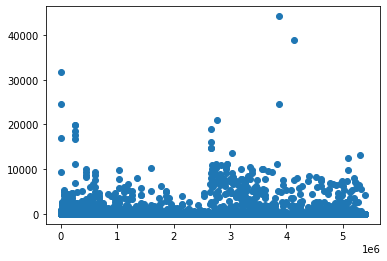

In [ ]:
plotNonBlockingTxnsLockTime(nonBlockingTxnsDf, isSaveFig=True)